In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image, ImageDraw
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch.nn as nn
import torch

import numpy as np
import cv2
from src.voc_dataset_2 import *
from src.region_proposal import RegionProposalNetwork, get_target_weights
from src.generate_anchor_data import AnchorDataGenerator
from src.generate_anchors import generate_anchors
from src.anchor_util import generate_all_anchors
from src.proposal import ProposalGenerator
from src.recall import recall

import pickle

In [2]:
dataset = VOCDataSet("data/", "train")
dataloader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=5, collate_fn=collate_fn)

In [30]:
checkpoint = torch.load("data/Experiments/rpn_stage_2/checkpoints/checkpoint_15.tar")

rpn = RegionProposalNetwork()
rpn.load_state_dict(checkpoint["state_dict"])
proposal = ProposalGenerator()
softmax_m = nn.Softmax2d()
iterator = iter(dataloader)

[ 83.33333333  83.33333333  83.33333333  66.66666667  66.66666667
  66.66666667  50.          16.66666667  16.66666667  16.66666667]


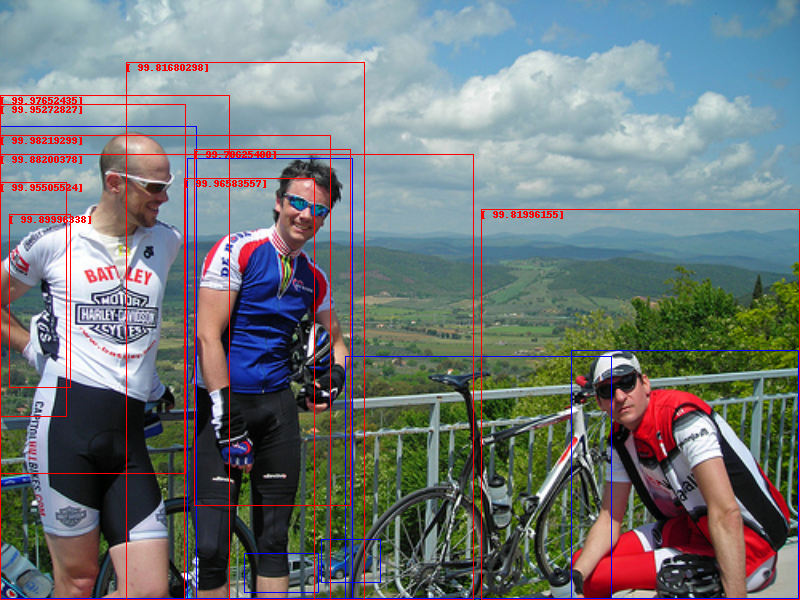

In [34]:
indices, image_arr, gt, labels, image_info = next(iterator)
image_arr = Variable(image_arr)
gt = Variable(gt)

logits, regressions = rpn(image_arr)
logits = logits.view(1, 2, 9 * logits.size(2), logits.size(3))
scores = softmax_m(logits)

bboxes, scores = proposal(regressions, scores, image_info[0, :])

image = image_arr.cpu().data.numpy()
image = image.squeeze().transpose(1, 2, 0) + PIXEL_MEANS
image = image.round().astype(np.uint8)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = Image.fromarray(image)

image_draw = ImageDraw.ImageDraw(image)

true_bbox = gt.data.numpy()[:, 1:]
for i in range(true_bbox.shape[0]):
    image_draw.rectangle(true_bbox[i, :], outline="blue")
    
pred_bbox = bboxes.data.numpy()
pred_score = scores.data.numpy()

for i in range(10):
    image_draw.text(pred_bbox[i, 1:3], str(pred_score[i] * 100.), fill="red")
    image_draw.rectangle(pred_bbox[i, 1:], outline="red")
    
print(recall([(pred_bbox[:, 1:], true_bbox)]) * 100.)

image